In [156]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import TextVectorization
import keras
import re
from keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

In [157]:
df = pd.read_csv('dialogs.csv', sep='\t')

In [158]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [159]:
#clean les données avec lemma stemma et stop words

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = word_tokenize(text)
    text = [word for word in text if not word in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    return text



In [160]:
df['cleaned_text_question'] = df['question'].apply(lambda x: clean_text(x))
df['cleaned_text_answer'] = df['answer'].apply(lambda x: clean_text(x))

TOKENIZATION

In [161]:
#tokenize les données 

vectorizerQ = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(df['cleaned_text_question'].values).batch(128)
vectorizerQ.adapt(text_ds)

vectorizerA = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(df['cleaned_text_answer'].values).batch(128)
vectorizerA.adapt(text_ds)

In [162]:
#Créer les données d'entrainement
X = vectorizerQ(np.array([s for s in df['cleaned_text_question'].values])).numpy()
y = vectorizerA(np.array([s for s in df['cleaned_text_answer'].values])).numpy()

print(X)
print(y)

[[993   0   0 ...   0   0   0]
 [  6 590   0 ...   0   0   0]
 [  6  90  11 ...   0   0   0]
 ...
 [  5 229   0 ...   0   0   0]
 [ 22 523  28 ...   0   0   0]
 [385  28 212 ...   0   0   0]]
[[  7 497   0 ...   0   0   0]
 [  7 108  12 ...   0   0   0]
 [ 72   0   0 ...   0   0   0]
 ...
 [ 18 389  22 ...   0   0   0]
 [387  22 194 ...   0   0   0]
 [ 66 314 585 ...   0   0   0]]


In [163]:
# params={
#     "vocab_size":2500,
#     "max_sequence_length":30,
#     "learning_rate":0.008,
#     "batch_size":149,
#     "lstm_cells":256,
#     "embedding_dim":256,
#     "buffer_size":10000
# }

In [164]:
#Créer le modèle
model = keras.models.Sequential()
model.add(Embedding(2500, 256))
model.add(LSTM(256))
model.add(LayerNormalization())
model.add(Dropout(0.5))
model.add(Dense(50, activation='softmax'))


In [165]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.008), 
              loss='categorical_crossentropy' , weighted_metrics=['accuracy'])

In [166]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 256)         640000    
                                                                 
 lstm_10 (LSTM)              (None, 256)               525312    
                                                                 
 layer_normalization_12 (Lay  (None, 256)              512       
 erNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 50)                12850     
                                                                 
Total params: 1,178,674
Trainable params: 1,178,674
Non-trainable params: 0
___________________________________________

In [167]:
history = model.fit(X, y, batch_size=64, epochs=200)

Epoch 1/200
59/59 [==============================] - 9s 119ms/step - loss: 7527.4053 - accuracy: 0.2215
Epoch 2/200
59/59 [==============================] - 10s 169ms/step - loss: 24639.4883 - accuracy: 0.2475
Epoch 3/200
59/59 [==============================] - 10s 175ms/step - loss: 56628.0820 - accuracy: 0.2421
Epoch 4/200
59/59 [==============================] - 10s 174ms/step - loss: 109067.3750 - accuracy: 0.2733
Epoch 5/200
59/59 [==============================] - 10s 175ms/step - loss: 173203.8438 - accuracy: 0.2736
Epoch 6/200
59/59 [==============================] - 10s 174ms/step - loss: 260590.7188 - accuracy: 0.2824
Epoch 7/200
59/59 [==============================] - 10s 173ms/step - loss: 342248.1875 - accuracy: 0.2695
Epoch 8/200
59/59 [==============================] - 10s 178ms/step - loss: 464410.2188 - accuracy: 0.2779
Epoch 9/200
59/59 [==============================] - 11s 181ms/step - loss: 615468.0000 - accuracy: 0.2854
Epoch 10/200
59/59 [======================

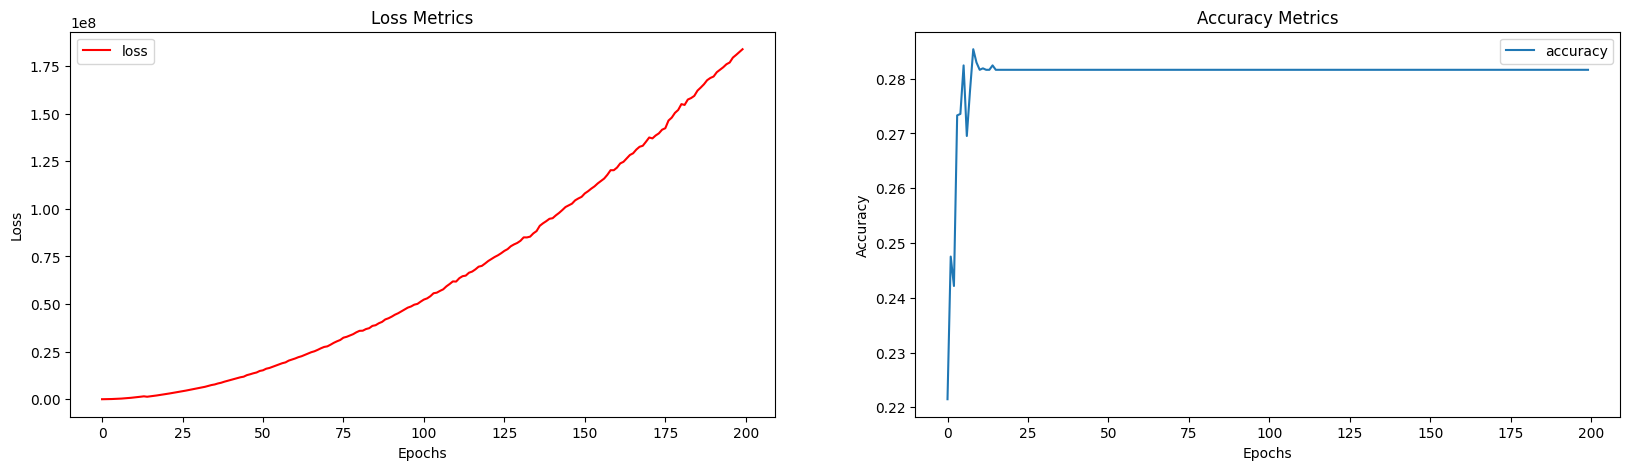

In [170]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [171]:
model.save('model.h5')

In [172]:
#evaluation du modèle
model.evaluate(X, y)

117/117 [==============================] - 4s 32ms/step - loss: 184823360.0000 - accuracy: 0.2816


[184823360.0, 0.28161072731018066]

In [178]:
chatbot = keras.models.load_model('model.h5')

def chat(question):
    question = clean_text(question)
    question = vectorizerQ(np.array([question])).numpy()
    answer = chatbot.predict(question)
    answer = vectorizerA.get_vocabulary()[np.argmax(answer)]
    return answer

In [179]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chat(text)}')
        print('========================')

In [180]:
print_conversation([
    'hi, how are you doing?	',
    'yes, I am doing great',
    'what is your name?',
    'are you a human or a bot?',
    'what is your favorite color?',
    'what is your favorite food?',
    'what is your favorite movie?',
])

You: hi, how are you doing?	
1/1 [==============================] - 0s 335ms/step
Bot: [UNK]
You: yes, I am doing great
1/1 [==============================] - 0s 20ms/step
Bot: [UNK]
You: what is your name?
1/1 [==============================] - 0s 21ms/step
Bot: [UNK]
You: are you a human or a bot?
1/1 [==============================] - 0s 20ms/step
Bot: [UNK]
You: what is your favorite color?
1/1 [==============================] - 0s 18ms/step
Bot: [UNK]
You: what is your favorite food?
1/1 [==============================] - 0s 18ms/step
Bot: [UNK]
You: what is your favorite movie?
1/1 [==============================] - 0s 19ms/step
Bot: [UNK]
